In [1]:
### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

from sklearn import set_config
set_config(display='diagram')

from neuralsens import partial_derivatives as ns

In [2]:
# Load the model from the model directory
import joblib


MLP_fit = joblib.load('../models/MLP_fit.pkl')

In [3]:
def plotModelGridError(model, figsize=(12, 6), xscale:str="linear", xscale2:str="linear", param1:str=None, param2:str=None):
    """Plot model cross-validation error along grid of hyperparameters

    Args:
        model: model to analyze
        figsize (tuple[float, float], optional): figure of plot size. Defaults to (12, 6).
        xscale (str, optional): Scale of x-axis of first plot. Defaults to "linear".
        xscale2 (str, optional): Scale of x-axis of second plot. Defaults to "linear".
        param1 (str, optional): First parameter of the grid to analyze. Defaults to None.
        param2 (str, optional): Second parameter of the grid to analyze. Defaults to None.

    Raises:
        TypeError: No hyperparameters found in grid, grid must have some hyperparameter to create plot
    """
    cv_r = model.cv_results_
    err = cv_r["mean_test_score"]
    std = cv_r["std_test_score"]
    param_names = list(model.cv_results_.keys())
    if param1 is not None and param2 is not None:
        param_names = ["param_"+param1, "param_"+param2]
    param_keys = [s for s in param_names if "param_" in s]
    params = [s.split("param_")[1] for s in param_keys]
        
    best_params = model.best_params_
    if not param_keys:
        raise TypeError("No hyperparameters encountered in grid.")
    if len(param_keys) > 1:
        grid1 = model.cv_results_[param_keys[0]].data
        cat1 = 'num'
        if not(type(grid1[0]) == int or type(grid1[0]) == float):
            grid1 = [p for p in list(grid1)]
            cat1 = 'cat'
        param_name1 = " ".join(params[0].split("__")[1].split("_"))
        grid2 = model.cv_results_[param_keys[1]].data
        cat2 = 'num'
        if not(type(grid2[0]) == int or type(grid2[0]) == float):
            grid2 = [p  for p in list(grid2)]
            cat2 = 'cat'
        param_name2 = " ".join(params[1].split("__")[1].split("_"))

        cols        = ['cv_error', 'cv_std']
        multi_index = pd.MultiIndex.from_tuples([(p1, p2) for p1, p2 in sorted(zip(grid1, grid2))], names=[param1, param2])
        dfe         = pd.DataFrame([(e, s) for e, s in zip(err, std)], columns=cols, index=multi_index)
        # First hyperparameter
        plt.figure(figsize=figsize)
        ax = plt.gca()
        dfe.unstack(level=1)['cv_error'].plot(ax=ax, style='o-', yerr=dfe.unstack(level=1)['cv_std'])
        #reset color cycle so that the marker colors match
        ax.set_prop_cycle(None)
        #plot the markers
        sc = dfe.unstack(level=1)['cv_error'].plot(figsize=(12,8), style='o-', markersize=5, ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[0:int(len(labels)/2)]
        labels = labels[0:int(len(labels)/2)]
        ax.legend(handles,labels,loc="lower right", title=param_name2)
        if not cat1 == 'cat':
            plt.plot(model.best_params_[params[0]], model.best_score_, marker="o", markersize=15, color="red")
        else:
            pos = list(dfe.unstack(level=1).index).index(model.best_params_[params[0]])
            plt.plot(pos, model.best_score_, marker="o", markersize=15, color="red")
        plt.title(f"Best model with {params[0]} = {str(best_params[params[0]])} and {params[1]} = {str(best_params[params[1]])} ")
        plt.xlabel(param_name1)
        plt.xscale(xscale)
        plt.show()
        # Second hyperparameter
        plt.figure(figsize=figsize)
        dfe.unstack(level=0)['cv_error'].plot(ax=plt.gca(), style='o-', yerr=dfe.unstack(level=1)['cv_std'])
        #reset color cycle so that the marker colors match
        plt.gca().set_prop_cycle(None)
        #plot the markers
        dfe.unstack(level=0)['cv_error'].plot(figsize=(12,8), style='o-', markersize=5, ax = plt.gca())
        handles, labels = plt.gca().get_legend_handles_labels()
        handles = handles[0:int(len(labels)/2)]
        labels = labels[0:int(len(labels)/2)]
        plt.gca().legend(handles,labels,loc="lower right", title=param_name1)
        if not cat2 == 'cat':
            plt.plot(model.best_params_[params[1]], model.best_score_, marker="o", markersize=15, color="red")
        else:
            pos = list(dfe.unstack(level=0).index).index(model.best_params_[params[1]])
            plt.plot(pos, model.best_score_, marker="o", markersize=15, color="red")
        plt.title(f"Best model with {params[0]} = {str(best_params[params[0]])} and {params[1]} = {str(best_params[params[1]])} ")
        plt.xlabel(param_name2)
        plt.xscale(xscale2)
        plt.show()
    else:
        grid=model.cv_results_[param_keys[0]].data
        if not(type(grid[0]) == int or type(grid[0]) == float):
            grid = [p for p in list(grid)]
        param_name= " ".join(params[0].split("__")[1].split("_"))
        
        plt.figure(figsize=figsize)
        plt.errorbar(grid, err, yerr=std, linestyle="None", ecolor='lightblue')
        plt.plot(grid, err, marker="o", markersize=10, c='lightblue')
        plt.plot(model.best_params_[params[0]], model.best_score_, marker="o", markersize=15, color="red")
        plt.title(f"Best model with {params[0]} = {str(best_params[params[0]])} ")
        plt.xlabel(param_name)
        plt.xscale(xscale)
        plt.show()
    return

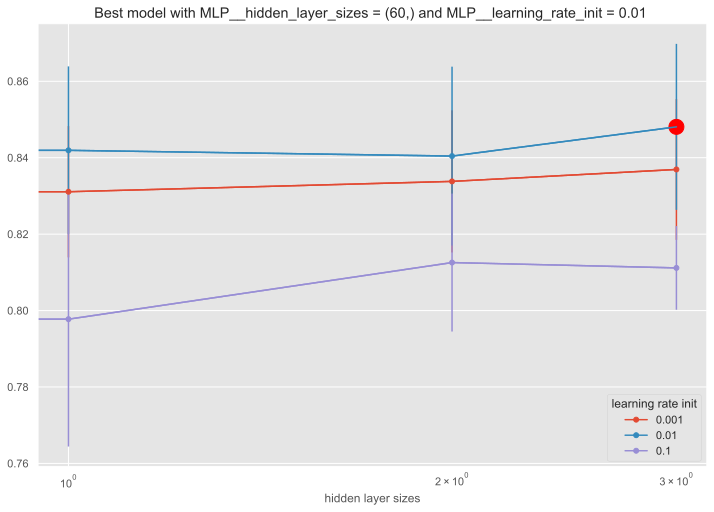

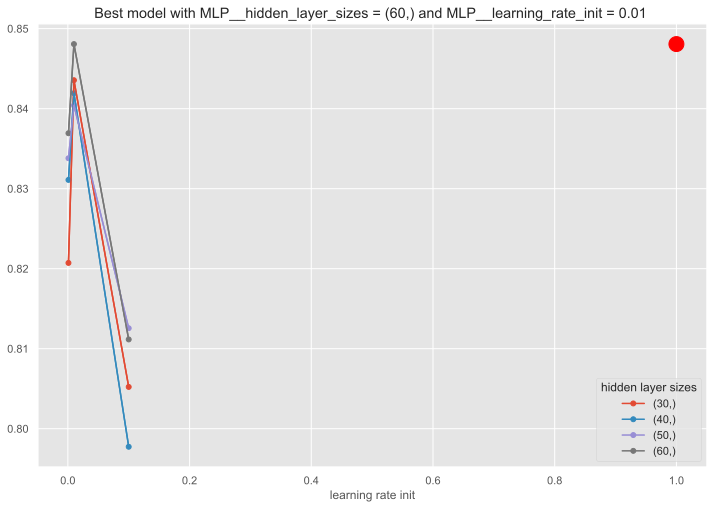

In [4]:
plotModelGridError(MLP_fit, xscale="log")

In [4]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')
columns = df.columns

features = ['strike', 'price', 'remaining', 'impliedVolatility']
target = 'midPrice'
df_reduced = df[features + [target]].dropna()

INPUTS = ['strike', 'price', 'remaining', 'impliedVolatility']
OUTPUT = 'midPrice'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0) #seed for replication
X_train.head()

,strike,price,remaining,impliedVolatility
53845,125.0,167.69,232,0.520787
101981,1790.0,134.81,204,0.000000
119036,75.0,117.34,8,1.257816
119590,1060.0,1021.30,8,0.337592
56474,270.0,156.45,8,1.649416


In [6]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

In [8]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

In [9]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

Training MAE: 14.440919879593688
Test MAE: 14.327104939919609
Training RMSE: 60.393250830753786
Test RMSE: 58.43148318335025
Training R2: 0.856898538833008
Test R2: 0.866658231345822


### 1. Cálculo de sensibilidades de las derivadas parciales con neuralsense

In [6]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS)


In [7]:
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[OUTPUT])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [8]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

In [9]:
sensmlp.summary()

Sensitivity analysis of [4, 60, 1] MLP network.

Sensitivity measures of each output:

$midPrice 

                              mean         std  mean_squared
num__strike            -231.631359  172.165552    288.607109
num__price              290.258796  193.985016    349.113671
num__remaining           15.836353   28.923671     32.975276
num__impliedVolatility   10.354003  192.087516    192.366367


In [10]:
sensmlp.info()

Sensitivity analysis of [4, 60, 1] MLP network.

116870 samples

Sensitivities of each output (only 5 first samples):

$midPrice 

   num__strike  num__price  num__remaining  num__impliedVolatility
0  -457.230224  540.438413       22.900644               77.741153
1   -17.198690   28.651249       -3.310391              -12.287545
2  -540.196824  589.924356        2.719281              -17.951186
3  -128.296554  124.216222       31.353952               32.313508
4   -81.769188  166.072749      -30.095900              -43.012287


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


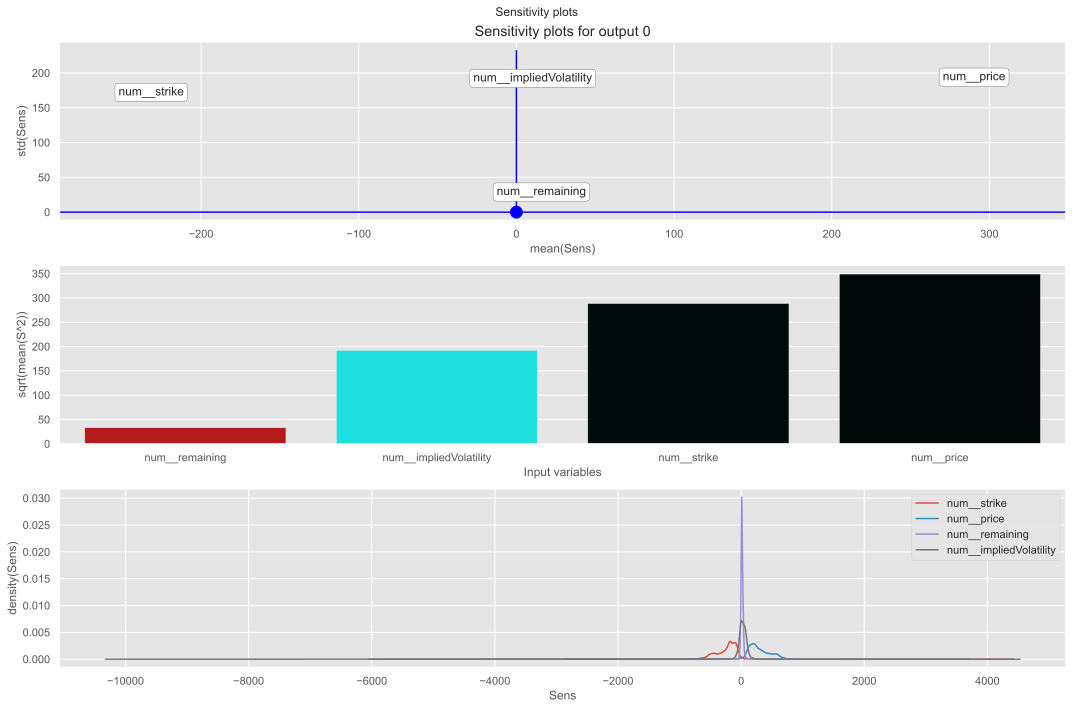

In [11]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

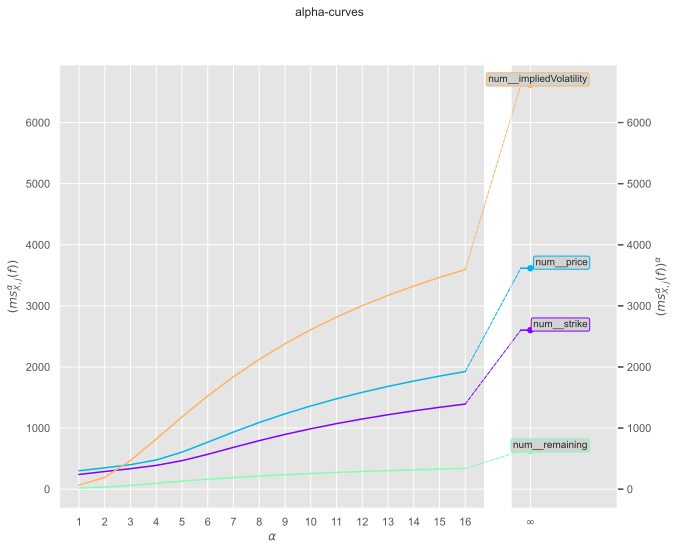

In [37]:
ns.alpha_sens_curves(sensmlp)

### 2. Cálculo analítico de griegas con black-scholes

In [ ]:
from scipy.stats import norm
import numpy as np

def compute_bs_greeks(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = norm.cdf(d1)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    return delta, vega, theta

In [27]:
df_greeks = df_reduced.copy()
r = 0.01  # o el valor que estés usando
greeks = df_greeks.apply(lambda row: compute_bs_greeks(row['price'], row['strike'], row['remaining'], r, row['impliedVolatility']), axis=1)
df_greeks[['Delta', 'Vega', 'Theta']] = pd.DataFrame(greeks.tolist(), index=df_greeks.index)

/var/folders/2m/mlv2fsg14t52l377d2x2_5t40000gn/T/ipykernel_23142/3152533364.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [29]:
def compute_alpha_curve(values, alphas=[1,2,5,10,20,50,100]):
    values = np.abs(values)
    curves = []
    for alpha in alphas:
        mean_pow = np.mean(values ** alpha)
        s_alpha = mean_pow ** (1 / alpha)
        curves.append(s_alpha)
    curves.append(np.max(values))  # α → ∞
    return curves

In [42]:
df_greeks['Theta']

0        -18.255207
1        -31.335867
2        -31.483056
3        -31.953989
4        -25.199966
            ...    
146083    -0.000021
146084    -0.000057
146085    -0.000070
146086    -0.000060
146087    -0.000032
Name: Theta, Length: 146088, dtype: float64

In [38]:
alphas = [1, 2, 3, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
delta_curve = compute_alpha_curve(df_greeks['Delta'], alphas)
vega_curve  = compute_alpha_curve(df_greeks['Vega'], alphas)
theta_curve = compute_alpha_curve(df_greeks['Theta'], alphas)

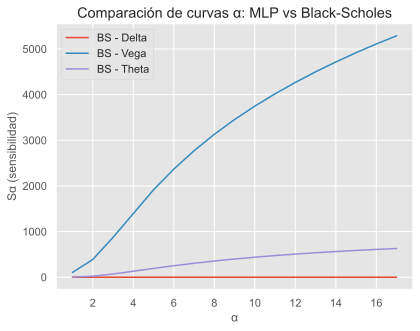

In [39]:
import matplotlib.pyplot as plt

alphas_plot = alphas + [np.inf]


plt.plot(alphas_plot, delta_curve, label='BS - Delta')

plt.plot(alphas_plot, vega_curve, label='BS - Vega')

plt.plot(alphas_plot, theta_curve, label='BS - Theta')

plt.legend()
plt.xlabel("α")
plt.ylabel("Sα (sensibilidad)")
plt.title("Comparación de curvas α: MLP vs Black-Scholes")
plt.grid(True)
plt.show()

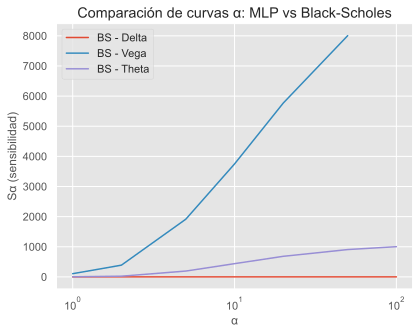

In [34]:
# Con log scale
plt.plot(alphas_plot, delta_curve, label='BS - Delta')
plt.plot(alphas_plot, vega_curve, label='BS - Vega')
plt.plot(alphas_plot, theta_curve, label='BS - Theta')
plt.legend()
plt.xlabel("α")
plt.ylabel("Sα (sensibilidad)")
plt.title("Comparación de curvas α: MLP vs Black-Scholes")
plt.xscale('log')
plt.grid(True)
plt.show()


In [2]:
import torch
x = torch.randn(100, requires_grad=True)
t = torch.randn(2, requires_grad=True)

# Definimos una función cualquiera para u(x, t)
def u(x, t):
    # Por ejemplo, una combinación lineal y no lineal
    return torch.sin(x) * torch.exp(t[0]) + torch.cos(x) * t[1]

# Calculamos u(x, t)
u_val = u(x, t)

# Derivadas de primer orden
dx = torch.autograd.grad(u_val, x, grad_outputs=torch.ones_like(u_val), create_graph=True)[0]
# Derivada de segundo orden
ddx = torch.autograd.grad(dx, x, grad_outputs=torch.ones_like(dx), create_graph=True)[0]